In [1]:
import pandas as pd, datetime as dt, numpy as np

### Preprocessing
#### Only needs to be run once

In [2]:
raw = pd.read_csv("C:PATH/TO_MICROMOBILITY_DATASET/Shared_Micromobility_Vehicle_Trips.csv", sep=',', low_memory=False)

In [3]:
# pre-preprocessing size
len(raw)

9989243

In [5]:
# filter conditions: durations in sec, distances in m
data = raw[(raw['Year'] > 2018) & (raw['Trip Duration'] > 15) & (raw['Trip Duration'] < 14400) & (raw['Trip Distance'] > 15) &
          (raw['Trip Distance'] < 40000) & (raw["Council District (Start)"].notnull()) & (raw["Census Tract Start"].notnull()) &
          (~raw["Council District (Start)"].isin(['None', '0', 'OUT_OF_BOUNDS'])) & (~raw["Council District (End)"].isin(['None', '0', 'OUT_OF_BOUNDS'])) & 
           (~raw["Census Tract Start"].isin(['None', '0', 'OUT_OF_BOUNDS'])) & (~raw["Census Tract End"].isin(['None', '0', 'OUT_OF_BOUNDS'])) &
          (raw["Vehicle Type"].isin(['scooter', 'bicycle']))].copy()

In [7]:
# post-preprocessing size
len(data)

7075038

In [8]:
data['sd'] = pd.to_datetime(data['Start Time']).dt.date
data['ed'] = pd.to_datetime(data['End Time']).dt.date

In [9]:
data.to_csv("preprocessed_trips.csv", sep=";", index=False)

## START HERE
#### Actual processing starts

In [2]:
data = pd.read_csv("C:/PATH/TO_PREPROCESSED/DATASET/preprocessed_trips.csv", sep=';')

In [3]:
data['sd'] = pd.to_datetime(data['sd']).dt.date
data['ed'] = pd.to_datetime(data['ed']).dt.date

In [29]:
data.dtypes

ID                           object
Device ID                    object
Vehicle Type                 object
Trip Duration                 int64
Trip Distance               float64
Start Time                   object
End Time                     object
Modified Date                object
Month                         int64
Hour                          int64
Day of Week                   int64
Council District (Start)      int64
Council District (End)        int64
Year                          int64
Census Tract Start            int64
Census Tract End              int64
sd                           object
ed                           object
dtype: object

In [4]:
council_district_list = sorted(data["Council District (Start)"].unique())

In [5]:
census_tract_list = sorted(data['Census Tract Start'].unique())

In [41]:
census_districts = data.groupby('Census Tract Start')

In [42]:
council_districts = data.groupby('Council District (Start)')

In [26]:
def relative_trip_data(districts, district_list, start_date=dt.date(2020, 3, 2), 
                       old_start_date=dt.date(2019, 3, 4), increment_weeks=1):
    increment = dt.timedelta(weeks=increment_weeks)
    columns = {"district":district_list}

    # start of week 10 in 2020
    current_date = start_date
    # start of week 10 in 2019
    year_ago = old_start_date

    for i in range(10,30):
        counts = []
        distances = []
        durations = []

        for code, district in districts:
            covid_week = district[(district['sd'] >= current_date) & (district['sd'] < current_date+increment)]
            baseline_week = district[(district['sd'] >= year_ago) & (district['sd'] < year_ago+increment)]
        
            count, distance, duration = np.nan, np.nan, np.nan
            if covid_week['ID'].count()>10 and baseline_week['ID'].count()>10:
                count = (covid_week['ID'].count()/baseline_week['ID'].count()-1)*100
                distance = (covid_week['Trip Distance'].median()/baseline_week['Trip Distance'].median()-1)*100
                duration = (covid_week['Trip Duration'].median()/baseline_week['Trip Duration'].median()-1)*100
        
            counts.append(count)
            distances.append(distance)
            durations.append(duration)
        count_name = "w"+str(i)+"_count"
        distance_name = "w"+str(i)+"_distance"
        duration_name = "w"+str(i)+"_duration"
    
        columns[count_name] = counts
        columns[distance_name] = distances
        columns[duration_name] = durations    

        current_date += increment
        year_ago += increment
    return columns

In [27]:
def absolute_trip_data(districts, district_list, start_date=dt.date(2020, 3, 2), 
                       old_start_date=dt.date(2019, 3, 4), increment_weeks=1):
    increment = dt.timedelta(weeks=increment_weeks)
    columns = {"district":district_list}

    # start of week 10 in 2020
    current_date = start_date
    # start of week 10 in 2019
    year_ago = old_start_date

    for i in range(10,30):
        counts = []
        counts_BL = []
        distances = []
        distances_BL = []

        for code, district in districts:
            covid_week = district[(district['sd'] >= current_date) & (district['sd'] < current_date+increment)]
            baseline_week = district[(district['sd'] >= year_ago) & (district['sd'] < year_ago+increment)]

            counts.append(covid_week['ID'].count())
            counts_BL.append(baseline_week['ID'].count())
            distances.append(covid_week['Trip Distance'].median())
            distances_BL.append(baseline_week['Trip Distance'].median())
            
        count_name = "w"+str(i)+"_count"
        count_name_BL = "w"+str(i)+"_count_BL"
        distance_name = "w"+str(i)+"_distance"
        distance_name_BL = "w"+str(i)+"_distance_BL"
    
        columns[count_name] = counts
        columns[count_name_BL] = counts_BL
        columns[distance_name] = distances
        columns[distance_name_BL] = distances_BL

        current_date += increment
        year_ago += increment
    return columns

In [43]:
census_relative_cols = relative_trip_data(census_districts, census_tract_list)
council_relative_cols = relative_trip_data(council_districts, council_district_list)
census_absolute_cols = absolute_trip_data(census_districts, census_tract_list)
council_absolute_cols = absolute_trip_data(council_districts, council_district_list)

In [45]:
census_relative = pd.DataFrame(data=census_relative_cols)
council_relative = pd.DataFrame(data=council_relative_cols)

census_absolute = pd.DataFrame(data=census_absolute_cols)
council_absolute = pd.DataFrame(data=council_absolute_cols)

In [54]:
# save the dataframes to csv, combine with district regions in e.g. QGIS
census_relative.to_csv("trips_relative_census.csv", sep=";", index=False)
council_relative.to_csv("trips_relative_council.csv", sep=";", index=False)

In [55]:
census_absolute.to_csv("trips_absolute_census.csv", sep=";", index=False)
council_absolute.to_csv("trips_absolute_council.csv", sep=";", index=False)

### Chord diagram

In [ ]:
# import packages relevant to this section
import matplotlib.pyplot as plt
from mpl_chord_diagram import chord_diagram

In [5]:
def create_filtered_dataset(all_data, start_date, increment, councils=True):
    study_period = all_data[(all_data['sd'] >= start_date) & (all_data['sd'] < start_date+increment)]
    if councils:
        districts = study_period.groupby(['Council District (Start)','Council District (End)'])
    else:
        districts = study_period.groupby(['Census Tract Start','Census Tract End'])
    
    return districts

In [6]:
def group_filter(group, min_depts):
    if len(group) < min_depts:
        return False
    else:
        return True

In [7]:
def create_df_base(districts):
    origins = []
    dests = []
    for key in districts.groups.keys():
        origins.append(key[0])
        dests.append(key[1])
        
    origins = set(origins)
    dests = set(dests)
    
    comb = origins.union(dests)
    
    empty_columns = []
    for dest in comb:
        value_list = [0 for i in range(len(comb))]
        empty_columns.append(value_list)
        
    df_base = pd.DataFrame(empty_columns, columns=comb, index=comb)
    return df_base, comb

In [8]:
def create_OD_matrix(districts, councils=True, min_depts=10):
    if councils:
        council_columns = ['Council District (Start)','Council District (End)']
    else:
        council_columns = ['Census Tract Start','Census Tract End']
    districts = districts.filter(lambda x: group_filter(x,min_depts)).groupby(council_columns)
    df_base, comb = create_df_base(districts)
    
    for code, dist in districts:
        df_base.at[code[1],code[0]] = len(dist)
        
    return df_base, list(comb)

In [44]:
def replace_codes_with_names(code_list):
    look_up = {48453001303:"ZILKER", 48453000603:"WEST\nUNIVERSITY",48453000601:"UNIVERSITY\nOF TEXAS",48453000604:"THE DRAG",
                    48453002304:"RIVERSIDE",48453001200:"OLD WEST\nAUSTIN",48453000902:"HOLLY / EAST\nCESAR CHAVEZ",
                              48453001100:"DOWNTOWN",48453001305:"BOULDIN\nCREEK"}
    name_list = []
    for code in code_list:
        if code in look_up.keys():
            name_list.append(look_up[code])
        else:
            name_list.append("")
    return name_list

In [39]:
"""
def sort_for_diagram(df, sort_cols, name_list):
    df['names'] = name_list
    df.sort_values(by=sort_cols,ascending=True, inplace=True)
    name_list=df['names'].tolist()
    df = df.drop(['names'], axis=1)
    
    return df, name_list
"""

[[ 0  1]
 [ 0  2]
 [ 0  3]
 ...
 [74 66]
 [74 72]
 [74 73]]
(5059, 2)


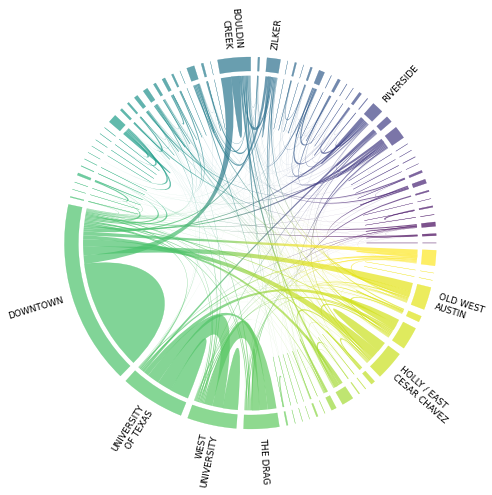

In [45]:
start_date = dt.date(2019,3,25)
districts = create_filtered_dataset(data, start_date, dt.timedelta(weeks=1), councils=False)
od_flows, codes = create_OD_matrix(districts, councils=False)
names = replace_codes_with_names(codes)
#od_flows, names = sort_for_diagram(od_flows, ['names', 48453001100], names)

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
#plt.rcParams['axes.titlepad'] = 40
#ax.set_title("Mobility flows between census tracts, {} week 13\nTotal trips: {}".format(start_date.year,od_flows.values.sum()))
chord_diagram(od_flows.to_numpy(), names=names, gap=0.025, width=0.075, pad=2.25,
use_gradient=True, fontsize=9, rotate_names=True, ax=ax)
plt.savefig("chord_diagrams/chords_ct_w13_2019.png", dpi=500, transparent=True, bbox_inches='tight', pad_inches=0.02)

[[ 0  1]
 [ 0  2]
 [ 0  4]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 15]
 [ 0 16]
 [ 1  0]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 3  1]
 [ 3  2]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 4 15]
 [ 4 16]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 15]
 [ 5 16]
 [ 5 17]
 [ 5 18]
 [ 5 19]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 13]
 [ 6 14]
 [ 6 15]
 [ 6 16]
 [ 6 17]
 [ 6 18]
 

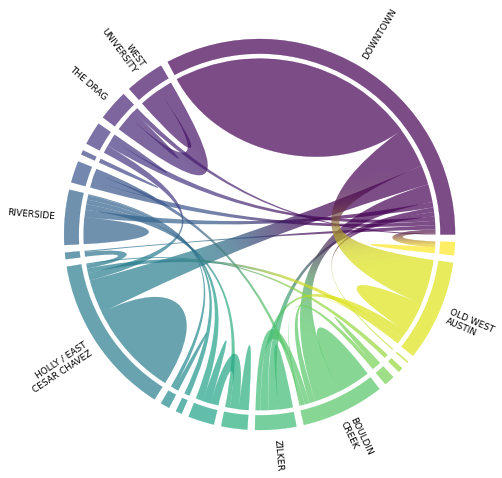

In [46]:
start_date = dt.date(2020,3,23)
districts = create_filtered_dataset(data, start_date, dt.timedelta(weeks=1), councils=False)
od_flows, codes = create_OD_matrix(districts, councils=False)
names = replace_codes_with_names(codes)
#od_flows, names = sort_for_diagram(od_flows, ['names', 48453001100], names)

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
#plt.rcParams['axes.titlepad'] = 40
#ax.set_title("Mobility flows between census tracts, {} week 13\nTotal trips: {}".format(start_date.year,od_flows.values.sum()))
chord_diagram(od_flows.to_numpy(), names=names, gap=0.025, width=0.075, pad=2.25,
use_gradient=True, fontsize=9, rotate_names=True, ax=ax)
plt.savefig("chord_diagrams/chords_ct_w13_2020.png", dpi=500, transparent=True, bbox_inches='tight', pad_inches=0.02)